In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, confusion_matrix
from imblearn.over_sampling import SMOTE
import shap
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load Data
data = pd.read_excel('../data/ANC_Raw.xlsx')
data.head()

,Age,\nEducational status,Marital status,\nResidence,Religion,Monthly income,Occupation,Husband's educational qualification,Media access,Distance to a health facility,\nPregnancy intension,Did you attend ANC visit during your last pregnancy within 3 months?,Who encouraged you to attend antenatal care visit?,Who took the decision for health care service?,Time to first antenatal care visit,ANC Visit,Parity,Total family members,Did you experience miscarriage before last pregnancy?
0,24,Secondary,Married,Rural,Muslim,Less than 20000 tk,Not working,Secondary,No,Not a big problem,Intended,No,Family,Respondent and husband,5.0,Yes,2,4,No
1,40,Primary,Married,Rural,Muslim,Less than 20000 tk,Not working,Primary,No,Not a big problem,Unintended,No,Family,Respondent and husband,9.0,Yes,4,5,Yes
2,20,Secondary,Married,Rural,Hindu,20000-40000,Not working,Higher secondary,Yes,Not a big problem,Unintended,No,Family,Respondent and husband,4.0,Yes,2,7,No
3,28,Higher secondary,Married,Rural,Hindu,20000-40000,Working,Higher secondary,Yes,Not a big problem,Intended,No,Family,Respondent and husband,4.5,Yes,3,5,No
4,38,Primary,Married,Rural,Muslim,Less than 20000 tk,Not working,Primary,No,Not a big problem,Unintended,Yes,Family,Respondent alone,2.0,Yes,3,5,No


In [3]:
# Clean Column Names
data.columns = data.columns.str.strip().str.replace('\\n', ' ')
data.head()

,Age,Educational status,Marital status,Residence,Religion,Monthly income,Occupation,Husband's educational qualification,Media access,Distance to a health facility,Pregnancy intension,Did you attend ANC visit during your last pregnancy within 3 months?,Who encouraged you to attend antenatal care visit?,Who took the decision for health care service?,Time to first antenatal care visit,ANC Visit,Parity,Total family members,Did you experience miscarriage before last pregnancy?
0,24,Secondary,Married,Rural,Muslim,Less than 20000 tk,Not working,Secondary,No,Not a big problem,Intended,No,Family,Respondent and husband,5.0,Yes,2,4,No
1,40,Primary,Married,Rural,Muslim,Less than 20000 tk,Not working,Primary,No,Not a big problem,Unintended,No,Family,Respondent and husband,9.0,Yes,4,5,Yes
2,20,Secondary,Married,Rural,Hindu,20000-40000,Not working,Higher secondary,Yes,Not a big problem,Unintended,No,Family,Respondent and husband,4.0,Yes,2,7,No
3,28,Higher secondary,Married,Rural,Hindu,20000-40000,Working,Higher secondary,Yes,Not a big problem,Intended,No,Family,Respondent and husband,4.5,Yes,3,5,No
4,38,Primary,Married,Rural,Muslim,Less than 20000 tk,Not working,Primary,No,Not a big problem,Unintended,Yes,Family,Respondent alone,2.0,Yes,3,5,No


In [4]:
# Handle Missing Values
data = data.dropna()

In [5]:
# Encode Categorical Variables
cat_cols = data.select_dtypes(include=['object']).columns
encoder = LabelEncoder()
for col in cat_cols:
    data[col] = encoder.fit_transform(data[col])

In [6]:
# Define Features and Target
X = data.drop('Did you attend ANC visit during your last pregnancy within 3 months?', axis=1)
y = data['Did you attend ANC visit during your last pregnancy within 3 months?']

In [7]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
# Scale Numerical Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
# Balance the Dataset with SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

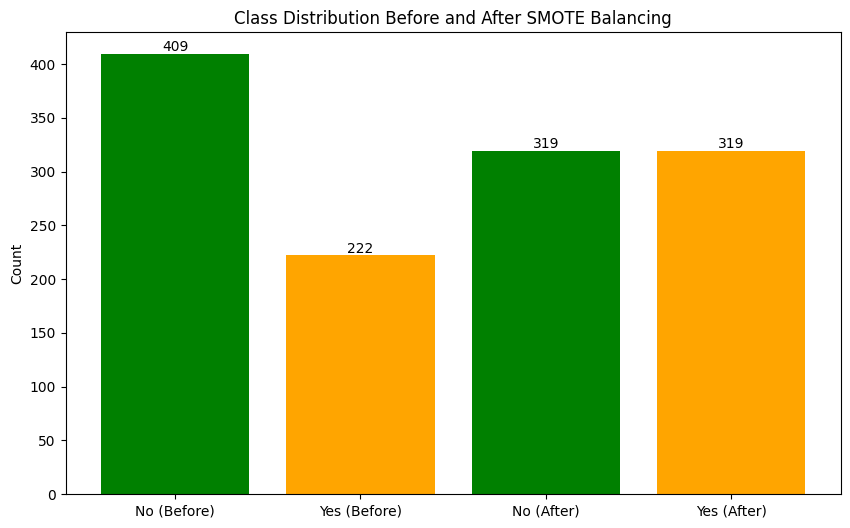

In [10]:
# Combined Visualization Before and After SMOTE
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
counts_before = y.value_counts()
counts_after = pd.Series(y_train_bal).value_counts()
bars = ax.bar(['No (Before)', 'Yes (Before)', 'No (After)', 'Yes (After)'],
              [counts_before[0], counts_before[1], counts_after[0], counts_after[1]],
              color=['green', 'orange', 'green', 'orange'])

# Annotate the bars with counts
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom')

ax.set_title('Class Distribution Before and After SMOTE Balancing')
ax.set_ylabel('Count')
plt.show()

In [11]:
# Define Models
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

In [12]:
# Cross-Validation and Model Comparison
results = []
for name, model in models.items():
    # Cross-validation on Unbalanced Data
    y_pred_unbal = cross_val_predict(model, X_train, y_train, cv=5, method="predict")
    y_prob_unbal = cross_val_predict(model, X_train, y_train, cv=5, method="predict_proba")[:, 1] if hasattr(model, "predict_proba") else None
    acc_unbal = accuracy_score(y_train, y_pred_unbal)
    auc_unbal = roc_auc_score(y_train, y_prob_unbal) if y_prob_unbal is not None else None

    # Cross-validation on Balanced Data
    y_pred_bal = cross_val_predict(model, X_train_bal, y_train_bal, cv=5, method="predict")
    y_prob_bal = cross_val_predict(model, X_train_bal, y_train_bal, cv=5, method="predict_proba")[:, 1] if hasattr(model, "predict_proba") else None
    acc_bal = accuracy_score(y_train_bal, y_pred_bal)
    auc_bal = roc_auc_score(y_train_bal, y_prob_bal) if y_prob_bal is not None else None

    # Append Results
    results.append({
        'Model': name,
        'Accuracy (Unbalanced)': acc_unbal,
        'AUC (Unbalanced)': auc_unbal,
        'Accuracy (Balanced)': acc_bal,
        'AUC (Balanced)': auc_bal
    })

# Create Results DataFrame
results_df = pd.DataFrame(results)
results_df

,Model,Accuracy (Unbalanced),AUC (Unbalanced),Accuracy (Balanced),AUC (Balanced)
0,Random Forest,0.942460,0.954529,0.943574,0.976577
1,Gradient Boosting,0.934524,0.932780,0.932602,0.955887
2,Logistic Regression,0.912698,0.928340,0.891850,0.931830
3,Support Vector Machine,0.902778,0.930780,0.918495,0.959012
4,Decision Tree,0.857143,0.853088,0.899687,0.899687
5,K-Nearest Neighbors,0.789683,0.826603,0.821317,0.898620
6,Naive Bayes,0.809524,0.863187,0.807210,0.869095


In [13]:
# Select Best Model Based on AUC
best_model_name = results_df.sort_values(by='AUC (Balanced)', ascending=False).iloc[0]['Model']
best_model = models[best_model_name]
print(f"\nBest Model: {best_model_name}")


Best Model: Random Forest


In [14]:
# Print Default Hyperparameters
print(f"\nDefault Hyperparameters for {best_model_name}:")
print(best_model.get_params())


Default Hyperparameters for Random Forest:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


In [15]:
# Define Random Forest Model
rf_unbalanced = RandomForestClassifier(random_state=42)
rf_balanced = RandomForestClassifier(random_state=42)
rf_optimized = RandomForestClassifier(random_state=42)

In [16]:
# Train on Unbalanced Data
rf_unbalanced.fit(X_train, y_train)
y_prob_unbalanced = rf_unbalanced.predict_proba(X_test)[:, 1]
auc_unbalanced = roc_auc_score(y_test, y_prob_unbalanced)
acc_unbalanced = accuracy_score(y_test, rf_unbalanced.predict(X_test))

In [17]:
# Train on Balanced Data
rf_balanced.fit(X_train_bal, y_train_bal)
y_prob_balanced = rf_balanced.predict_proba(X_test)[:, 1]
auc_balanced = roc_auc_score(y_test, y_prob_balanced)
acc_balanced = accuracy_score(y_test, rf_balanced.predict(X_test))

In [ ]:
# Hyperparameter Optimization
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(rf_optimized, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train_bal, y_train_bal)
rf_optimized = grid_search.best_estimator_
y_prob_optimized = rf_optimized.predict_proba(X_test)[:, 1]
auc_optimized = roc_auc_score(y_test, y_prob_optimized)
acc_optimized = accuracy_score(y_test, rf_optimized.predict(X_test))

In [22]:
print(f"Test Accuracy: {acc_test}")
print(f"Test AUC: {auc_test}")

NameError: name 'acc_test' is not defined

In [23]:
# Visualize Model Performance Before and After Balancing
performance_df = pd.DataFrame({
    'Model': ['Unbalanced', 'Balanced', 'Optimized'],
    'Accuracy': [acc_unbalanced, acc_balanced, acc_optimized],
    'AUC': [auc_unbalanced, auc_balanced, auc_optimized]
})

# Plot Model Performance
plt.figure(figsize=(10, 6))
x = np.arange(len(performance_df['Model']))
width = 0.35

plt.bar(x - width/2, performance_df['Accuracy'], width, label='Accuracy', color='skyblue')
plt.bar(x + width/2, performance_df['AUC'], width, label='AUC', color='orange')

plt.xticks(x, performance_df['Model'])
plt.title('Model Performance Before and After Balancing')
plt.xlabel('Model')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend()
plt.show()

NameError: name 'acc_optimized' is not defined

In [24]:
# Plot ROC Curves
fpr_unbalanced, tpr_unbalanced, _ = roc_curve(y_test, y_prob_unbalanced)
fpr_balanced, tpr_balanced, _ = roc_curve(y_test, y_prob_balanced)
fpr_optimized, tpr_optimized, _ = roc_curve(y_test, y_prob_optimized)

plt.figure(figsize=(10, 6))
plt.plot(fpr_unbalanced, tpr_unbalanced, label=f"RF on Unbalanced Data (AUC = {auc_unbalanced:.2f})", color='blue')
plt.plot(fpr_balanced, tpr_balanced, label=f"RF on Balanced Data (AUC = {auc_balanced:.2f})", color='orange')
plt.plot(fpr_optimized, tpr_optimized, label=f"RF after Optimization (AUC = {auc_optimized:.2f})", color='red')
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve Comparison of Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

NameError: name 'y_prob_optimized' is not defined

In [ ]:
# SHAP Analysis for Feature Importance
explainer = shap.TreeExplainer(rf_optimized)

# Compute SHAP values
shap_values = explainer.shap_values(X_train_bal_df)

# Global Feature Importance Plot
# For classification models with shap_values as a list (e.g., multiple classes), choose class 1
shap.summary_plot(shap_values[1], X_train_bal_df, plot_type="bar")

AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.